In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv


In [2]:
# ライブラリのロード
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import io

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')
train = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')

In [4]:
sample_submission.count()

id        200000
target    200000
dtype: int64

In [5]:
print(sample_submission)

            id  target
0            5     0.5
1            6     0.5
2            8     0.5
3            9     0.5
4           11     0.5
...        ...     ...
199995  499983     0.5
199996  499984     0.5
199997  499987     0.5
199998  499994     0.5
199999  499998     0.5

[200000 rows x 2 columns]


In [6]:
test.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,A,LF,A,A,A,A,B,D,D,B,0.708120,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,A,MC,A,A,A,B,D,B,D,B,0.611637,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,A,FN,A,A,A,B,B,D,D,B,0.456289,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592
3,9,B,L,C,A,F,BI,A,E,AX,A,HK,A,A,A,A,B,D,B,B,0.338692,0.666092,0.598943,0.561971,0.806347,0.735983,0.538724,0.381566,0.481660,0.348514,0.325723
4,11,A,F,A,B,F,BI,A,AH,I,A,HX,A,A,A,A,D,D,D,B,0.631671,0.772229,0.479572,0.767745,0.252454,0.354810,0.178920,0.763479,0.562491,0.466261,0.585781


In [7]:
train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,F,KV,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


# 統計量確認

In [8]:
test.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,249723.611455,0.505388,0.493960,0.516425,0.475286,0.504772,0.501180,0.487315,0.502684,0.488331,0.469813,0.508974
std,144363.694402,0.207417,0.212695,0.214752,0.216919,0.227199,0.241375,0.211335,0.203793,0.178895,0.194999,0.203926
min,5.000000,-0.044929,0.090478,0.098591,-0.038178,0.171321,-0.036337,-0.005648,0.096067,0.013554,0.215540,0.113059
25%,124460.250000,0.344748,0.317788,0.326210,0.292777,0.279413,0.275422,0.322365,0.353388,0.359121,0.309888,0.368999
50%,249679.500000,0.479633,0.463195,0.470893,0.392118,0.480299,0.554723,0.517318,0.436139,0.411318,0.407066,0.446578
75%,374661.250000,0.638773,0.693882,0.704745,0.645803,0.725272,0.735137,0.607454,0.646104,0.612508,0.588008,0.583082
max,499998.000000,1.006825,1.011597,1.012128,0.965609,0.867198,0.848617,0.964635,1.033760,1.053155,1.007189,1.007168


In [9]:
train.describe()

,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250183.425697,0.504749,0.494073,0.516632,0.474235,0.504848,0.502257,0.488229,0.501739,0.488074,0.469496,0.508230,0.264870
std,144320.334812,0.206788,0.213037,0.214851,0.216636,0.227474,0.241243,0.211335,0.203496,0.179048,0.194516,0.203393,0.441265
min,0.000000,-0.049562,0.084480,0.094493,-0.045316,0.168071,-0.036379,0.005199,0.090901,0.024139,0.214866,0.097789,0.000000
25%,125399.750000,0.344985,0.317363,0.326047,0.292249,0.279303,0.276442,0.323914,0.353054,0.358915,0.309934,0.368312,0.000000
50%,250192.500000,0.479650,0.463170,0.471247,0.387564,0.479858,0.554768,0.518089,0.435404,0.410908,0.407477,0.446576,0.000000
75%,375246.250000,0.637657,0.693992,0.704625,0.644950,0.725779,0.735225,0.608537,0.642023,0.612725,0.586793,0.581957,1.000000
max,499999.000000,1.004559,1.009958,1.016600,0.952187,0.858578,0.853022,0.966553,1.035818,1.055885,1.005652,1.011331,1.000000


# 欠損確認

In [10]:
test.isnull().sum()

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
dtype: int64

In [11]:
train.isnull().sum()

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64

→欠損なし

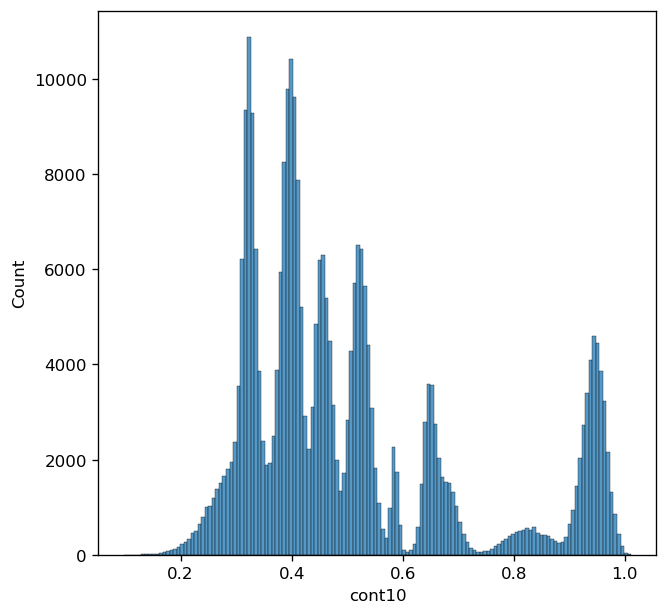

In [12]:
plt.figure(figsize=(6, 6), dpi=120)
sns.histplot(train['cont10'])
plt.show()

In [13]:
train.groupby('cat10').count()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
cat10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AA,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273,273
AB,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259
AC,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147,147
AD,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489,489
AE,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279
V,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470,470
W,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196


In [14]:
# trainとtestをunion
train.loc[:,'test'] = 0
test.loc[:,'test'] = 1

df = train.append(test, ignore_index=False)

In [15]:
# 数値タイプ以外のオブジェクトをOne-Hotエンコード
import category_encoders as CategoryEncoder
objectList = df.select_dtypes(include = object).columns.values.tolist()
ce_tmp = CategoryEncoder.BinaryEncoder(cols = objectList, handle_unknown = "impute")
trans_df = ce_tmp.fit_transform(df)

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
print(trans_df.shape)


(500000, 101)


In [17]:
trans_df.head()


,id,cat0_0,cat0_1,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,cat2_0,cat2_1,cat2_2,cat2_3,cat2_4,cat2_5,cat3_0,cat3_1,cat3_2,cat3_3,cat3_4,cat4_0,cat4_1,cat4_2,cat4_3,cat4_4,cat4_5,cat5_0,cat5_1,cat5_2,cat5_3,cat5_4,cat5_5,cat5_6,cat5_7,cat6_0,cat6_1,cat6_2,cat6_3,cat6_4,cat7_0,cat7_1,cat7_2,cat7_3,cat7_4,cat7_5,cat7_6,cat8_0,cat8_1,cat8_2,cat8_3,cat8_4,...,cat8_6,cat9_0,cat9_1,cat9_2,cat9_3,cat9_4,cat9_5,cat10_0,cat10_1,cat10_2,cat10_3,cat10_4,cat10_5,cat10_6,cat10_7,cat10_8,cat10_9,cat11_0,cat11_1,cat12_0,cat12_1,cat13_0,cat13_1,cat14_0,cat14_1,cat15_0,cat15_1,cat15_2,cat16_0,cat16_1,cat16_2,cat17_0,cat17_1,cat17_2,cat18_0,cat18_1,cat18_2,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,test
0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0.0,0
1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0.0,0
2,2,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0.0,0
3,3,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0.0,0
4,4,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1.0,0


In [18]:
tmp_df = trans_df[df['test'] == 0]


import sklearn.model_selection

# データの20%をテストに、80%を学習に利用する
train_df, valid_df = sklearn.model_selection.train_test_split(tmp_df, test_size=0.2, train_size = 0.8, random_state = 0)

train_df = train_df.drop(columns='id')
train_df = train_df.drop(columns='test')

train_ds = lgb.Dataset(train_df.drop(columns='target'), label=train_df['target'])

valid_df = valid_df.drop(columns='id')
valid_df = valid_df.drop(columns='test')

valid_ds = lgb.Dataset(valid_df.drop(columns='target'), label=valid_df['target'])

In [19]:
print(len(train_df))
print(len(valid_df))

240000
60000


In [20]:
test_df = trans_df[df['test'] == 1 ]
test_df = test_df.drop(columns='target')
test_df = test_df.drop(columns='test')

In [21]:
params = {
 'task': 'train',
 'boosting_type': 'gbdt',    
 'objective': 'regression',
 'metric': 'auc',
 'learning_rate': 0.05,

 'feature_pre_filter': False,
 'lambda_l1': 7.371221651922364e-07,
 'lambda_l2': 0.12342789643836635,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.9321963910217531,
 'bagging_freq': 4,
 'min_child_samples': 20,

 'num_iterations': 9999,
 'early_stopping_round': 50,
 'verbosity': -1
}

In [22]:
categorical_feature = train_df.drop(columns='target').columns.values.tolist()

In [23]:
print(categorical_feature)


['cat0_0', 'cat0_1', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_3', 'cat1_4', 'cat2_0', 'cat2_1', 'cat2_2', 'cat2_3', 'cat2_4', 'cat2_5', 'cat3_0', 'cat3_1', 'cat3_2', 'cat3_3', 'cat3_4', 'cat4_0', 'cat4_1', 'cat4_2', 'cat4_3', 'cat4_4', 'cat4_5', 'cat5_0', 'cat5_1', 'cat5_2', 'cat5_3', 'cat5_4', 'cat5_5', 'cat5_6', 'cat5_7', 'cat6_0', 'cat6_1', 'cat6_2', 'cat6_3', 'cat6_4', 'cat7_0', 'cat7_1', 'cat7_2', 'cat7_3', 'cat7_4', 'cat7_5', 'cat7_6', 'cat8_0', 'cat8_1', 'cat8_2', 'cat8_3', 'cat8_4', 'cat8_5', 'cat8_6', 'cat9_0', 'cat9_1', 'cat9_2', 'cat9_3', 'cat9_4', 'cat9_5', 'cat10_0', 'cat10_1', 'cat10_2', 'cat10_3', 'cat10_4', 'cat10_5', 'cat10_6', 'cat10_7', 'cat10_8', 'cat10_9', 'cat11_0', 'cat11_1', 'cat12_0', 'cat12_1', 'cat13_0', 'cat13_1', 'cat14_0', 'cat14_1', 'cat15_0', 'cat15_1', 'cat15_2', 'cat16_0', 'cat16_1', 'cat16_2', 'cat17_0', 'cat17_1', 'cat17_2', 'cat18_0', 'cat18_1', 'cat18_2', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10']

In [24]:
#ハイパラチューニング

#model = opt_lgb.train(
#    params,
#    train_ds,
#    valid_names=['train', 'valid'],
#    valid_sets=[train_ds, valid_ds],
#    verbose_eval=100,
#    early_stopping_rounds=100,
#    categorical_feature=categorical_feature
#)

model = lgb.train(
    params,
    train_ds,
    valid_names=['train', 'valid'],
    valid_sets=[train_ds, valid_ds],
    verbose_eval=50,
    categorical_feature=categorical_feature,
)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat0_0', 'cat0_1', 'cat10_0', 'cat10_1', 'cat10_2', 'cat10_3', 'cat10_4', 'cat10_5', 'cat10_6', 'cat10_7', 'cat10_8', 'cat10_9', 'cat11_0', 'cat11_1', 'cat12_0', 'cat12_1', 'cat13_0', 'cat13_1', 'cat14_0', 'cat14_1', 'cat15_0', 'cat15_1', 'cat15_2', 'cat16_0', 'cat16_1', 'cat16_2', 'cat17_0', 'cat17_1', 'cat17_2', 'cat18_0', 'cat18_1', 'cat18_2', 'cat1_0', 'cat1_1', 'cat1_2', 'cat1_

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.852592	valid's auc: 0.849697
[100]	train's auc: 0.860448	valid's auc: 0.857434
[150]	train's auc: 0.86463	valid's auc: 0.861429
[200]	train's auc: 0.867131	valid's auc: 0.863839
[250]	train's auc: 0.868921	valid's auc: 0.86555
[300]	train's auc: 0.870278	valid's auc: 0.866835
[350]	train's auc: 0.871154	valid's auc: 0.867651
[400]	train's auc: 0.87207	valid's auc: 0.868473
[450]	train's auc: 0.872786	valid's auc: 0.869152
[500]	train's auc: 0.873431	valid's auc: 0.869733
[550]	train's auc: 0.87404	valid's auc: 0.870282
[600]	train's auc: 0.874612	valid's auc: 0.870815
[650]	train's auc: 0.875035	valid's auc: 0.871173
[700]	train's auc: 0.875353	valid's auc: 0.871407
[750]	train's auc: 0.875718	valid's auc: 0.871707
[800]	train's auc: 0.876142	valid's auc: 0.872086
[850]	train's auc: 0.876438	valid's auc: 0.872324
[900]	train's auc: 0.876727	valid's auc: 0.872547
[950]	train's auc: 0.877032	valid's auc: 0.8

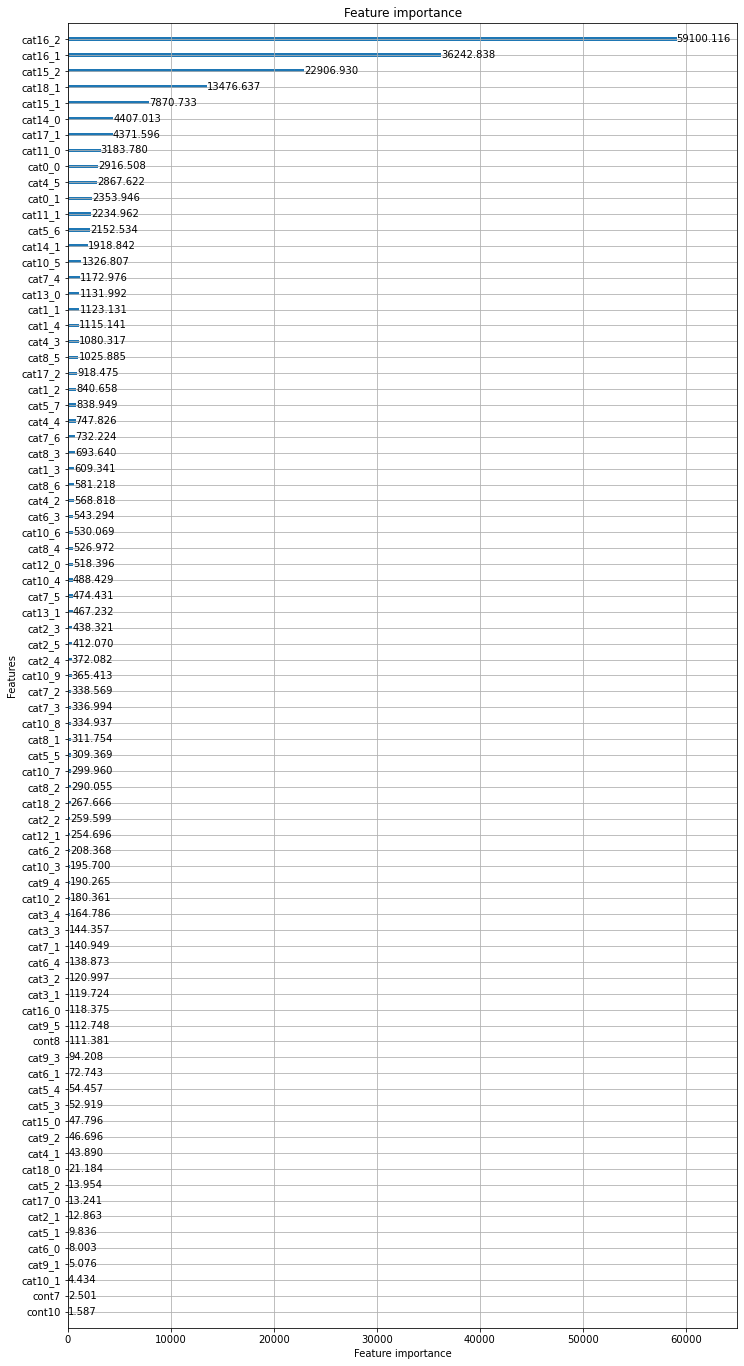

In [25]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, importance_type='gain', figsize=(12, 24))
plt.show()

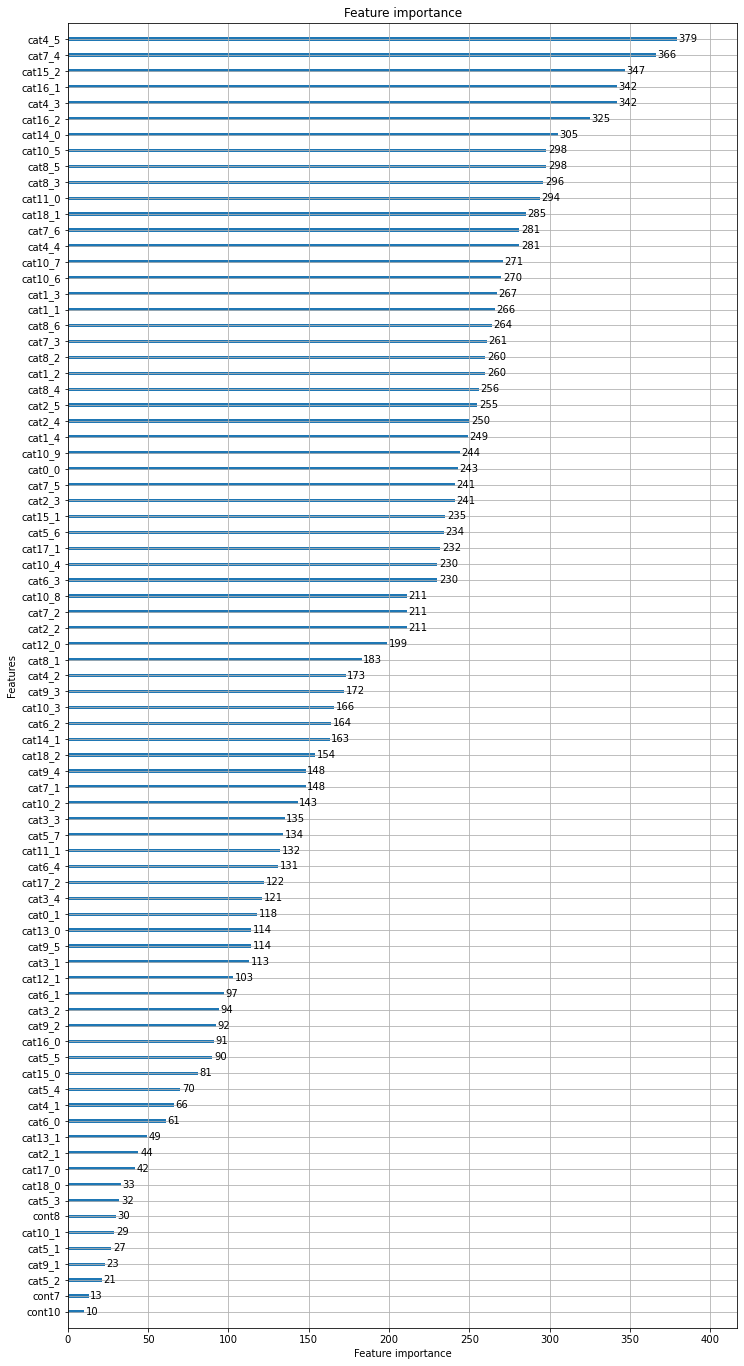

In [26]:
lgb.plot_importance(model, importance_type='split', figsize=(12, 24))
plt.show()

#prediction

In [27]:
val_pred = model.predict(test_df.drop(columns='id'))

In [28]:
print(val_pred)


[0.12828944 0.24613369 0.02827875 ... 0.58285306 0.14017675 0.42782545]


In [29]:
result_tmp = test_df
result_tmp['target'] = val_pred

In [30]:
result = result_tmp.loc[:,['id','target']]


In [31]:
print(result)


            id    target
0            5  0.128289
1            6  0.246134
2            8  0.028279
3            9  0.110060
4           11  0.138625
...        ...       ...
199995  499983  0.919297
199996  499984 -0.004103
199997  499987  0.582853
199998  499994  0.140177
199999  499998  0.427825

[200000 rows x 2 columns]


In [32]:
result.to_csv('submission.csv', index=False)